# Introduction
Use *Forecasting Patient Volume and Resource Demand to Better Inform Nurse Staffing Decisions* by Schienker et al. to predict Average Daily Census (ADC, daily number of filled beds).
### Problem Statement
Use Database of Daily Census Count per department to forecast ADC more accuractely than Schienker (**Error**).
### Experimental Procedure
EDA: Prepare data for machine learning pipeline. Dive into seasonality, averaging, differencing...
<br>Feature engineering: Split data by lag (tn-l for l features) and forecast distance (yn+m for m predictions). 
<br>Modeling: Run LSTM and GRU RNN models and ARIMA model.
<br>Results: Compare models to test set.
<br>Evaluate: Error compared to Schienker.

In [1]:
# Utilities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import time
# Modeling
import statsmodels.api as sm
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARIMA
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM,GRU,Dropout, TimeDistributed
import xgboost as xgb
from sklearn.linear_model import LinearRegression

Using TensorFlow backend.


In [2]:
df = pd.read_excel('AvgDailyCensusPerDept2Years.xlsx')
df.sort_values(by='EffectiveDAte',inplace=True)
display(df.head())
print(df.dtypes)

,EffectiveDAte,DepartmentName,DepartmentAbbreviation,AverageCensusCount
6139,2016-01-01,COMPREHENSIVE CARE PGM,CCP,8
6741,2016-01-01,3 NORTH,3N,10
7901,2016-01-01,F2-MATERNITY,F2,21
4737,2016-01-01,PICN 1,PICN1,11
4061,2016-01-01,SEQ SPEC CARE NURSERY,SEQN,4


EffectiveDAte             datetime64[ns]
DepartmentName                    object
DepartmentAbbreviation            object
AverageCensusCount                 int64
dtype: object


# EDA

In [3]:
name_counts = df['DepartmentName'].value_counts()
print("Unique Names",len(name_counts))
abb_counts = df['DepartmentAbbreviation'].value_counts()
print("Unique Abbreviations",len(abb_counts))

Unique Names 44
Unique Abbreviations 44


In [4]:
# look at PICUs ACC and average ACC per day
df_PICU = df[df['DepartmentName'] == "PICU"].reset_index(drop=True)
df_alldept = df.groupby(['EffectiveDAte']).mean()
display(df_PICU.head())

,EffectiveDAte,DepartmentName,DepartmentAbbreviation,AverageCensusCount
0,2016-03-28,PICU,PICU,22
1,2016-03-29,PICU,PICU,22
2,2016-03-30,PICU,PICU,22
3,2016-03-31,PICU,PICU,21
4,2016-04-01,PICU,PICU,21


In [5]:
# and PICU ADC and Total ADC
df_alldept_M = df.groupby(pd.Grouper(key='EffectiveDAte',freq='M')).mean()
df_PICU_M = df_PICU.groupby(pd.Grouper(key='EffectiveDAte',freq='M')).mean()

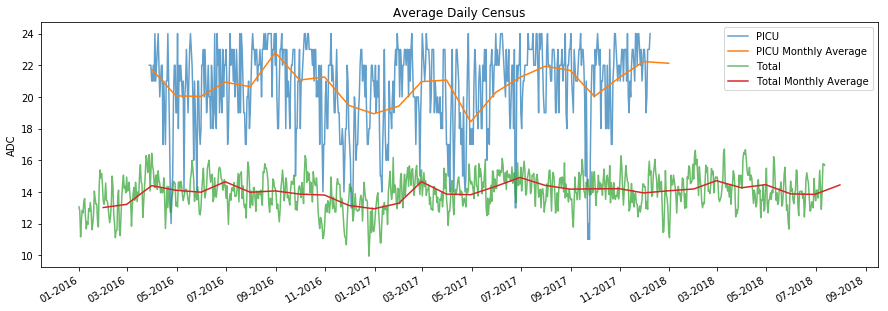

In [6]:
#plot ADC
plt.figure(figsize=(15,5))
plt.plot(df_PICU['EffectiveDAte'],df_PICU['AverageCensusCount'],label="PICU",alpha=.7)
plt.plot(df_PICU_M,label="PICU Monthly Average",alpha=1)
plt.plot(df_alldept,label="Total",alpha=.7)
plt.plot(df_alldept_M,label="Total Monthly Average",alpha=1)
plt.title("Average Daily Census")
plt.ylabel("ADC")
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.show()

The Time Series shows PICU's daily and monthly ADC compared to the all departments. There is a large variability and no signs of trends or seasonality. The problem at hand requires an accurate forecast of 30 days in order to accurately staff nurses a reasonable time in the future. Also, note that the PICU time series covers almost 2 whole years or 21 months.

In [7]:
freq=30 # assume monthly frequency
s_PICU = sm.tsa.seasonal_decompose(df_PICU['AverageCensusCount'].values,freq=freq)

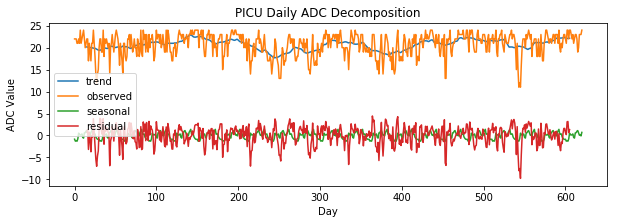

In [8]:
# look at trend, seasonal, resid and observed
plt.figure(figsize=(10,3))
plt.plot(s_PICU.trend,label="trend")
plt.plot(s_PICU.observed,label="observed")
plt.plot(s_PICU.seasonal,label="seasonal")
plt.plot(s_PICU.resid,label="residual")
plt.title("PICU Daily ADC Decomposition")
plt.ylabel("ADC Value")
plt.xlabel("Day")
plt.legend()
plt.show()

To further iterate the point above, there is some indication of a trend and seasonality, but residuals still plague the decomposition of the original signal. This time series is not simple to model and will require powerful machine learning algorithms to accurately forecast the target variable. Limited features are available, only previous values and the dates of records are given.
<br>Luckily, algorithms like ARIMA are able to take only a series as input and generate forecasts based on three parameters: p,q and d. To find the order of each parameter we need to look at the difference series and ensure stationarity.

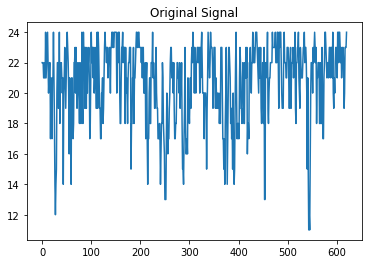

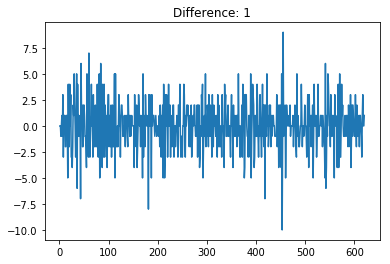

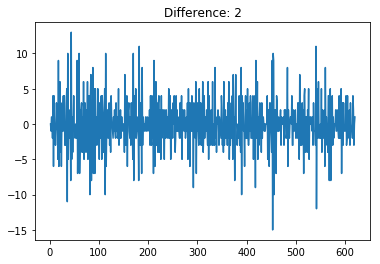

In [9]:
# find order of stationarity
plt.plot(range(len(df_PICU.index)),df_PICU["AverageCensusCount"])
plt.title("Original Signal")
plt.show()
# difference: 1
dif_1 = df_PICU['AverageCensusCount'] - df_PICU['AverageCensusCount'].shift()
plt.plot(range(len(dif_1)),dif_1)
plt.title("Difference: 1")
plt.show()
# difference: 2
dif_2 = dif_1 - dif_1.shift()
plt.plot(range(len(dif_2)),dif_2)
plt.title("Difference: 2")
plt.show()

The original signal is not stationary, so we look at the first few difference orders to get a stationary signal. The first two orders are stationary, so we'll include these orders in our parameter grid search for ARIMA.

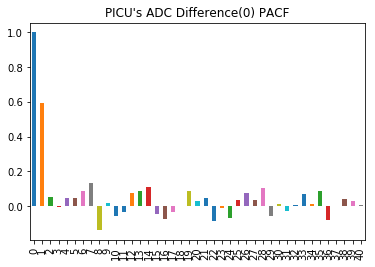

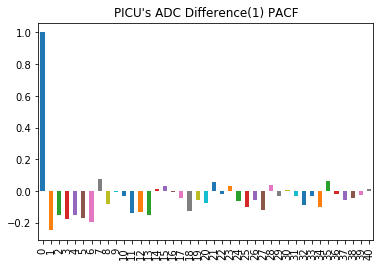

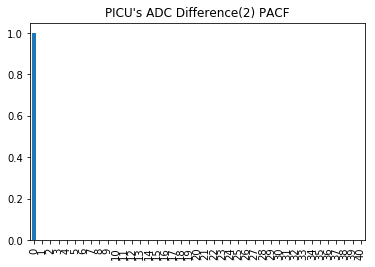

In [10]:
# look at (partial) autocorrelation of differenced signals
x_acf = pd.DataFrame()
x_acf['signal'] = pacf(df_PICU['AverageCensusCount'])
x_acf['signal'].plot(kind='bar')
plt.title("PICU's ADC Difference(0) PACF")
plt.show()
x_acf['dif_1'] = pacf(dif_1[1:])
x_acf['dif_1'].plot(kind='bar')
plt.title("PICU's ADC Difference(1) PACF")
plt.show()
x_acf['dif_2'] = pacf(dif_2[1:])
x_acf['dif_2'].plot(kind='bar')
plt.title("PICU's ADC Difference(2) PACF")
plt.show()

The partial autocorrelation plots for the previous series give us a list of parameters to try for p, our autoregressive term which tells us how many previous values to consider. The values that stand out above are 1,3,6,and 8.

                              ARIMA Model Results                               
Dep. Variable:     D.AverageCensusCount   No. Observations:                  620
Model:                   ARIMA(2, 1, 7)   Log Likelihood               -1325.269
Method:                         css-mle   S.D. of innovations              2.049
Date:                  Sun, 12 Aug 2018   AIC                           2672.538
Time:                          18:00:48   BIC                           2721.265
Sample:                               1   HQIC                          2691.478
                                                                                
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.0023      0.007      0.316      0.752      -0.012       0.016
ar.L1.D.AverageCensusCount    -0.9982      0.324     -3.081      0.

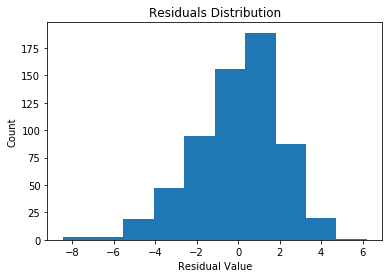

In [11]:
model = ARIMA(df_PICU['AverageCensusCount'], order=(2,1,7))
model_fit = model.fit()
print(model_fit.summary())
plt.hist(model_fit.resid)
plt.title("Residuals Distribution")
plt.xlabel("Residual Value")
plt.ylabel("Count")
plt.show()

After running a grid search on order values, the combination 2,1,7 for p,q, and d respectively show the lowest AIC score and normally distributed residuals. Notice that a few terms are not significant (where p values are higher than 0.05). This may hinder our model, nevertheless, it is the best form of ARIMA we have.

# Feature Engineering

In [12]:
# sequential split
def seq_split(df,window_size=7):
    X = df.copy()
    df_temp = df.copy()
    for i in range(window_size):
        X = pd.concat([df_temp.shift(i+1),X],axis=1)
    return X.dropna(axis=0)

In [13]:
test_size = 60
train_size = len(df_PICU.index) - test_size
window_size=7
df_PICU_train = seq_split(df_PICU['AverageCensusCount'][:train_size],window_size=window_size)
df_PICU_test = seq_split(df_PICU['AverageCensusCount'][train_size:],window_size=window_size)
print("Training DataFrame")
display(df_PICU_train.head())
X_PICU_train = df_PICU_train.iloc[:,:-1]
Y_PICU_train = df_PICU_train.iloc[:,-1]
X_PICU_test = df_PICU_test.iloc[:,:-1]
Y_PICU_test = df_PICU_test.iloc[:,-1]
# reshape for LSTM
X_PICU_train = np.reshape(X_PICU_train.values, (len(X_PICU_train), 1, X_PICU_train.shape[1]))
X_PICU_test = np.reshape(X_PICU_test.values, (len(X_PICU_test), 1, X_PICU_test.shape[1]))
print("Training X")
print(X_PICU_train[:5,0,:])
print("Training Y")
display(Y_PICU_train.head())

Training DataFrame


,AverageCensusCount,AverageCensusCount,AverageCensusCount,AverageCensusCount,AverageCensusCount,AverageCensusCount,AverageCensusCount,AverageCensusCount
7,22.0,22.0,22.0,21.0,21.0,22.0,21.0,24
8,22.0,22.0,21.0,21.0,22.0,21.0,24.0,21
9,22.0,21.0,21.0,22.0,21.0,24.0,21.0,22
10,21.0,21.0,22.0,21.0,24.0,21.0,22.0,23
11,21.0,22.0,21.0,24.0,21.0,22.0,23.0,24


Training X
[[22. 22. 22. 21. 21. 22. 21.]
 [22. 22. 21. 21. 22. 21. 24.]
 [22. 21. 21. 22. 21. 24. 21.]
 [21. 21. 22. 21. 24. 21. 22.]
 [21. 22. 21. 24. 21. 22. 23.]]
Training Y


7     24
8     21
9     22
10    23
11    24
Name: AverageCensusCount, dtype: int64

# Modeling

### ARIMA

In [14]:
# setup arima
order = (2,1,7)
X_arima_train = df_PICU['AverageCensusCount'][:train_size]
Y_arima_test = df_PICU['AverageCensusCount'][train_size:]
arima_model = ARIMA(X_arima_train, 
                      order=order
                     )
arima_model_fit = arima_model.fit()

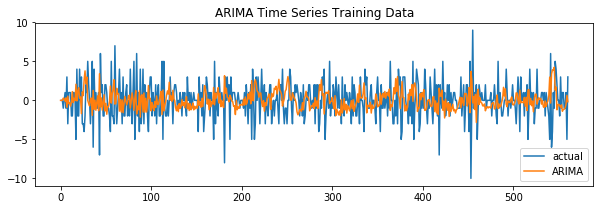

In [15]:
# in-sample predictions
arima_train_predict = arima_model_fit.predict(start=1,end=train_size)
# trained values
plt.figure(figsize=(10,3))
X_arima_dif_1 = X_arima_train - X_arima_train.shift()
plt.plot(range(len(X_arima_dif_1.index)),X_arima_dif_1,label="actual")
plt.plot(range(len(arima_train_predict)),arima_train_predict,label="ARIMA")
plt.legend()
plt.title("ARIMA Time Series Training Data")
plt.show()

ARIMA Error 1.7676323132108778


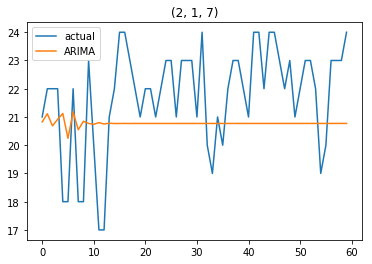

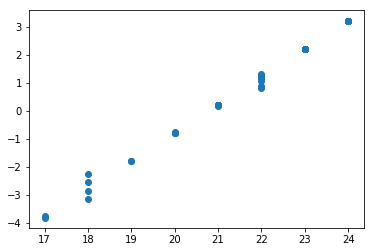

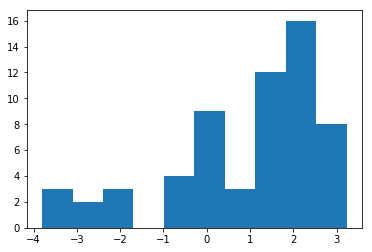

In [16]:
# out-of-sample forecast
arima_forecast,_,_ = arima_model_fit.forecast(test_size)
# error
arima_res = Y_arima_test.values - arima_forecast
arima_mae = np.mean(abs(arima_res))
print("ARIMA Error",arima_mae)
#plot out-of-sample time series
plt.plot(range(len(Y_arima_test.index)),Y_arima_test,label="actual")
plt.plot(range(len(Y_arima_test.index)),arima_forecast,label="ARIMA")
plt.title(order)
plt.legend()
plt.show()
# plot errors
plt.scatter(Y_arima_test,arima_res)
plt.show()
# histogram of errors
plt.hist(arima_res)
plt.show()

The model performs well with a Mean Absolute Error under 2.0 (our target value). However, from the time series forecast plot, we see that the model resorts to predicting the same value after 10 days. This may not be the best suited model for production given its weak long-term forecasting abilities.

### Linear Models

In [17]:
# xgboost features
df_PICU_xgb = df_PICU[['EffectiveDAte','AverageCensusCount']].reset_index(drop=True)
df_PICU_xgb['year'] = df_PICU_xgb['EffectiveDAte'].dt.year
df_PICU_xgb['month'] = df_PICU_xgb['EffectiveDAte'].dt.month
df_PICU_xgb['dayofweek'] = df_PICU_xgb['EffectiveDAte'].dt.dayofweek
df_PICU_xgb['lpch_main_open'] = 0
df_PICU_xgb.loc[df_PICU_xgb["EffectiveDAte"] < '2017-12-09']['lpch_main_open'] = 1
offset=30
window=30
for i in range(len(df_PICU_xgb.index))[offset+window:]:
    win_range = df_PICU_xgb.loc[i-window-offset:i-offset,'AverageCensusCount']
    df_PICU_xgb.loc[i,'prev_mean'] = win_range.mean()
    df_PICU_xgb.loc[i,'prev_std'] = win_range.std()

X_PICU_xgb = df_PICU_xgb[['year','month','dayofweek','lpch_main_open','prev_mean','prev_std']]
Y_PICU_xgb = df_PICU_xgb['AverageCensusCount']
# sequential train test split
X_PICU_xgb_train = X_PICU_xgb.iloc[X_PICU_xgb.index[:train_size]]
X_PICU_xgb_test = X_PICU_xgb.iloc[X_PICU_xgb.index[train_size:]]
Y_PICU_xgb_train = Y_PICU_xgb.iloc[Y_PICU_xgb.index[:train_size]]
Y_PICU_xgb_test = Y_PICU_xgb.iloc[Y_PICU_xgb.index[train_size:]]

In [18]:
# linear regression
lr_model = LinearRegression()
lr_features = ["prev_mean","prev_std","dayofweek","month"]#,"year","lpch_main_open"]
lr_X_train = X_PICU_xgb_train[lr_features].fillna(0)
lr_X_test = X_PICU_xgb_test[lr_features].fillna(0)
lr_model.fit(lr_X_train, Y_PICU_xgb_train)
print("Linear Regression R Squared",lr_model.score(lr_X_train,Y_PICU_xgb_train))

Linear Regression R Squared 0.032511437797456466


Linear Regression MAE: 1.7842


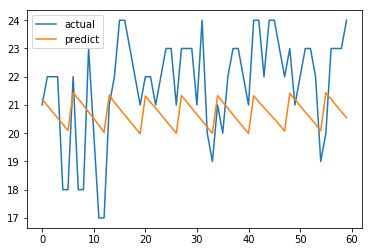

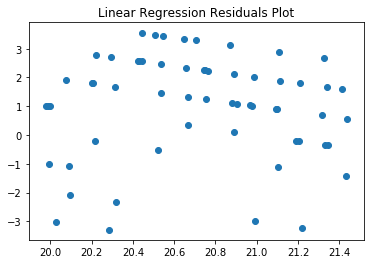

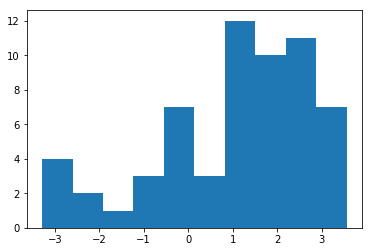

In [19]:
lr_pred = lr_model.predict(lr_X_test)
print("Linear Regression MAE: {:0.4f}".format(np.mean(abs(Y_PICU_xgb_test-lr_pred))))
# plot time series
plt.plot(range(len(Y_PICU_xgb_test.index)),Y_PICU_xgb_test,label='actual')
plt.plot(lr_pred,label='predict')
plt.legend()
plt.show()
# error
lr_res = Y_PICU_xgb_test - lr_pred
plt.scatter(lr_pred,lr_res)
plt.title("Linear Regression Residuals Plot")
plt.show()
plt.hist(lr_res)
plt.show()

Like ARIMA, the Linear Regression model performs with low error. However, unlike ARIMA, it shows a forecast all the way out to the 30 day mark, albeit a consistent triangular wave. This model has promise in indicating how staffing requirements change on a month-to-month basis.
<br>Notice also, that the distribution of residuals is normal, an assumption of linear models.

In [20]:
params = {"objective":"reg:linear",
          "eta":0.1,
          "max_depth":3,
          "silent":1,
          "eval_metric":"mae",
          "min_child_weight":5,
          "subsample":.75,
          "colsample_bytree":0.7,
          "seed":42}

In [21]:
# setup XGBoost
xgb_train = xgb.DMatrix(X_PICU_xgb_train, label=Y_PICU_xgb_train)
xgb_test = xgb.DMatrix(X_PICU_xgb_test, label=Y_PICU_xgb_test)
watchlist = [ (xgb_train,'train'), (xgb_test, 'test') ]
xgb_PICU_model = xgb.train(params, xgb_train, num_boost_round=500, evals=watchlist, early_stopping_rounds=20)

[0]	train-mae:18.104	test-mae:19.2146
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 20 rounds.
[1]	train-mae:16.2985	test-mae:17.4091
[2]	train-mae:14.6794	test-mae:15.7865
[3]	train-mae:13.2091	test-mae:14.3163
[4]	train-mae:11.8994	test-mae:12.9982
[5]	train-mae:10.7101	test-mae:11.798
[6]	train-mae:9.65253	test-mae:10.7306
[7]	train-mae:8.70374	test-mae:10.0192
[8]	train-mae:7.8514	test-mae:9.15463
[9]	train-mae:7.08457	test-mae:8.5778
[10]	train-mae:6.41004	test-mae:7.87521
[11]	train-mae:5.81092	test-mae:7.23635
[12]	train-mae:5.28395	test-mae:6.66547
[13]	train-mae:4.81299	test-mae:6.29173
[14]	train-mae:4.39135	test-mae:5.87819
[15]	train-mae:4.01914	test-mae:5.50143
[16]	train-mae:3.70139	test-mae:5.11674
[17]	train-mae:3.41766	test-mae:4.82892
[18]	train-mae:3.16655	test-mae:4.6485
[19]	train-mae:2.95347	test-mae:4.40399
[20]	train-mae:2.76888	test-mae:4.20671
[21]	train-mae:2.60586	test-mae:4.

XGB Error 2.765193208058675


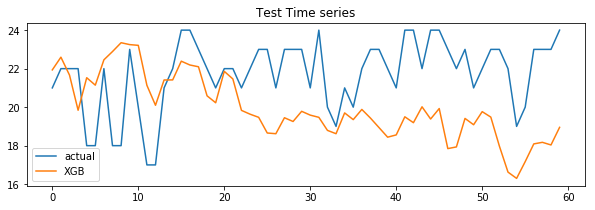

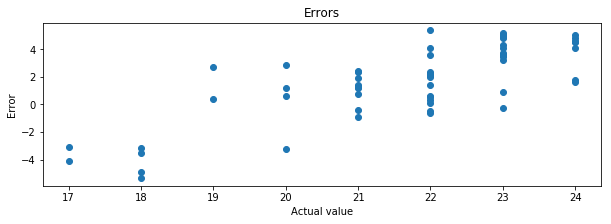

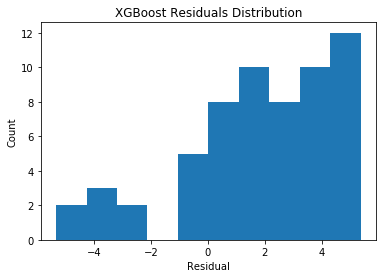

In [22]:
# predict
Y_PICU_xgb_pred = xgb_PICU_model.predict(xgb.DMatrix(X_PICU_xgb_test))
# error
PICU_xgb_res = Y_PICU_xgb_test-Y_PICU_xgb_pred
PICU_xgb_mae = np.mean(abs(PICU_xgb_res))
print("XGB Error",PICU_xgb_mae)
# plot time series
plt.figure(figsize=(10,3))
plt.plot(range(len(Y_PICU_xgb_test.index)),Y_PICU_xgb_test,label="actual")
plt.plot(Y_PICU_xgb_pred,label="XGB")
plt.title("Test Time series")
plt.legend()
plt.show()
# plot errors
plt.figure(figsize=(10,3))
plt.scatter(Y_PICU_xgb_test,PICU_xgb_res)
plt.title("Errors")
plt.xlabel("Actual value")
plt.ylabel("Error")
plt.show()
# histogram of errors
plt.hist(PICU_xgb_res)
plt.title("XGBoost Residuals Distribution")
plt.ylabel("Count")
plt.xlabel("Residual")
plt.show()

Although the error is higher than desired, the XGBoost model is the only model thus far to realize the trends underlying the ADC patterns. Each upward and downward trend in the actual time series is met with a similar trend in the predicted series.
<br>Our XGBoost model tends to underestimate, shown by the density of our errors located above zero. However, the time series shows adaptability and may be useful in showing how patient volume changes by the day as well as by the month. If our error can be minimized this model is definitely our choice for production.

### GRU

In [23]:
# forecast 30 days
# setup target variable
rnn_forecast_size = 30
Y_temp_seq_train = seq_split(Y_PICU_train,window_size=rnn_forecast_size)
Y_temp_seq_test = seq_split(Y_PICU_test,window_size=rnn_forecast_size)
#reshape outputs
Y_PICU_train_rnn = np.reshape(Y_temp_seq_train.values,(Y_temp_seq_train.shape[0],1,Y_temp_seq_train.shape[1]))
Y_PICU_test_rnn = np.reshape(Y_temp_seq_test.values,(Y_temp_seq_test.shape[0],1,Y_temp_seq_test.shape[1]))
X_PICU_train_rnn = X_PICU_train[:-rnn_forecast_size]
X_PICU_test_rnn = X_PICU_test[:-rnn_forecast_size]
#print(X_PICU_train_rnn.shape,Y_PICU_train_rnn.shape,Y_temp_seq_test.shape)

In [24]:
gru = Sequential()
gru.add(GRU(64,input_shape=(X_PICU_train_rnn.shape[1],X_PICU_train_rnn.shape[2]),return_sequences=True))
gru.add(TimeDistributed(Dense(rnn_forecast_size+1)))

# compile and fit the model
gru.compile(loss='mean_squared_error', 
               optimizer='adam',
               metrics=['mae'])
# fit
start_time = time.time()
gru_history = gru.fit(X_PICU_train_rnn, Y_PICU_train_rnn, 
                            epochs=50, 
                            batch_size=8, 
                            shuffle=False,
                            verbose=1,
                            validation_data=(X_PICU_test_rnn,Y_PICU_test_rnn)
                           )
end_time = time.time()-start_time

Train on 524 samples, validate on 23 samples
Epoch 1/50
524/524 [==============================] - 1s 1ms/step - loss: 360.7296 - mean_absolute_error: 18.7710 - val_loss: 341.8530 - val_mean_absolute_error: 18.4094
Epoch 2/50
524/524 [==============================] - 0s 226us/step - loss: 239.0791 - mean_absolute_error: 15.1848 - val_loss: 224.3870 - val_mean_absolute_error: 14.8830
Epoch 3/50
524/524 [==============================] - 0s 556us/step - loss: 151.0250 - mean_absolute_error: 11.9555 - val_loss: 146.0452 - val_mean_absolute_error: 11.9684
Epoch 4/50
524/524 [==============================] - 0s 367us/step - loss: 93.4483 - mean_absolute_error: 9.2624 - val_loss: 90.8961 - val_mean_absolute_error: 9.3915
Epoch 5/50
524/524 [==============================] - 0s 353us/step - loss: 53.8006 - mean_absolute_error: 6.8502 - val_loss: 54.0749 - val_mean_absolute_error: 7.1765
Epoch 6/50
524/524 [==============================] - 0s 381us/step - loss: 30.8922 - mean_absolute_error

Epoch 50/50
524/524 [==============================] - 0s 338us/step - loss: 6.8796 - mean_absolute_error: 2.1451 - val_loss: 4.4560 - val_mean_absolute_error: 1.8364


Training time: 10.649 seconds
Loss 4.456
Mean Absolute Error 1.836


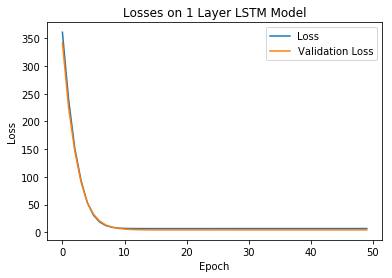

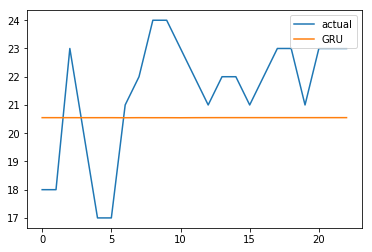

In [25]:
# show score
print("Training time: {:0.3f} seconds".format(end_time))
gru_predict = gru.predict(X_PICU_test_rnn)
gru_score = gru.evaluate(X_PICU_test_rnn,Y_PICU_test_rnn,verbose=0)
print("Loss {:0.3f}".format(gru_score[0]))
print("Mean Absolute Error {:0.3f}".format(gru_score[1]))
# plot loss
plt.plot(gru_history.history['loss'],label="Loss")
plt.plot(gru_history.history['val_loss'],label="Validation Loss")
plt.title("Losses on 1 Layer LSTM Model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
# plot test series
plt.plot(Y_PICU_test_rnn[:,0,0],label='actual')
plt.plot(gru_predict[:,0,0],label='GRU')
plt.legend()
plt.show()

### LSTM

In [26]:
lstm_1 = Sequential()
lstm_1.add(LSTM(32, input_shape=(X_PICU_train_rnn.shape[1],X_PICU_train_rnn.shape[2]),return_sequences=True))
lstm_1.add(TimeDistributed(Dense(rnn_forecast_size+1)))

# compile and fit the model
lstm_1.compile(loss='mean_squared_error', 
               optimizer='adam',
               metrics=['mae'])
start_time = time.time()
lstm_1_history = lstm_1.fit(X_PICU_train_rnn, Y_PICU_train_rnn, 
                            epochs=150, 
                            batch_size=8, 
                            shuffle=False,
                            verbose=1,
                            validation_data=(X_PICU_test_rnn,Y_PICU_test_rnn)
                           )
end_time = time.time()-start_time

Train on 524 samples, validate on 23 samples
Epoch 1/150
524/524 [==============================] - 1s 2ms/step - loss: 410.7160 - mean_absolute_error: 20.0929 - val_loss: 443.0015 - val_mean_absolute_error: 20.9906
Epoch 2/150
524/524 [==============================] - 0s 355us/step - loss: 370.6692 - mean_absolute_error: 19.0698 - val_loss: 403.2222 - val_mean_absolute_error: 20.0201
Epoch 3/150
524/524 [==============================] - 0s 379us/step - loss: 334.5631 - mean_absolute_error: 18.0977 - val_loss: 366.3825 - val_mean_absolute_error: 19.0780
Epoch 4/150
524/524 [==============================] - 0s 349us/step - loss: 302.3375 - mean_absolute_error: 17.1846 - val_loss: 333.2630 - val_mean_absolute_error: 18.1893
Epoch 5/150
524/524 [==============================] - 0s 422us/step - loss: 273.1415 - mean_absolute_error: 16.3133 - val_loss: 302.9009 - val_mean_absolute_error: 17.3347
Epoch 6/150
524/524 [==============================] - 0s 372us/step - loss: 246.4221 - mean

Epoch 49/150
524/524 [==============================] - 0s 284us/step - loss: 6.7914 - mean_absolute_error: 2.1515 - val_loss: 4.7339 - val_mean_absolute_error: 1.9014
Epoch 50/150
524/524 [==============================] - 0s 275us/step - loss: 6.7859 - mean_absolute_error: 2.1472 - val_loss: 4.6641 - val_mean_absolute_error: 1.8851
Epoch 51/150
524/524 [==============================] - 0s 316us/step - loss: 6.7823 - mean_absolute_error: 2.1437 - val_loss: 4.6069 - val_mean_absolute_error: 1.8717
Epoch 52/150
524/524 [==============================] - 0s 408us/step - loss: 6.7801 - mean_absolute_error: 2.1408 - val_loss: 4.5604 - val_mean_absolute_error: 1.8606
Epoch 53/150
524/524 [==============================] - 0s 293us/step - loss: 6.7789 - mean_absolute_error: 2.1384 - val_loss: 4.5228 - val_mean_absolute_error: 1.8515
Epoch 54/150
524/524 [==============================] - 0s 279us/step - loss: 6.7783 - mean_absolute_error: 2.1365 - val_loss: 4.4924 - val_mean_absolute_error:

Epoch 98/150
524/524 [==============================] - 0s 288us/step - loss: 6.7946 - mean_absolute_error: 2.1319 - val_loss: 4.3938 - val_mean_absolute_error: 1.8200
Epoch 99/150
524/524 [==============================] - 0s 288us/step - loss: 6.7948 - mean_absolute_error: 2.1318 - val_loss: 4.3933 - val_mean_absolute_error: 1.8199
Epoch 100/150
524/524 [==============================] - 0s 249us/step - loss: 6.7962 - mean_absolute_error: 2.1322 - val_loss: 4.3913 - val_mean_absolute_error: 1.8194
Epoch 101/150
524/524 [==============================] - 0s 238us/step - loss: 6.7957 - mean_absolute_error: 2.1317 - val_loss: 4.3929 - val_mean_absolute_error: 1.8198
Epoch 102/150
524/524 [==============================] - 0s 237us/step - loss: 6.7959 - mean_absolute_error: 2.1318 - val_loss: 4.3947 - val_mean_absolute_error: 1.8203
Epoch 103/150
524/524 [==============================] - 0s 228us/step - loss: 6.7959 - mean_absolute_error: 2.1319 - val_loss: 4.3958 - val_mean_absolute_er

524/524 [==============================] - 0s 363us/step - loss: 6.7982 - mean_absolute_error: 2.1321 - val_loss: 4.3957 - val_mean_absolute_error: 1.8206
Epoch 147/150
524/524 [==============================] - 0s 333us/step - loss: 6.7979 - mean_absolute_error: 2.1325 - val_loss: 4.3960 - val_mean_absolute_error: 1.8206
Epoch 148/150
524/524 [==============================] - 0s 403us/step - loss: 6.7987 - mean_absolute_error: 2.1324 - val_loss: 4.3925 - val_mean_absolute_error: 1.8198
Epoch 149/150
524/524 [==============================] - 0s 372us/step - loss: 6.7981 - mean_absolute_error: 2.1322 - val_loss: 4.3962 - val_mean_absolute_error: 1.8207
Epoch 150/150
524/524 [==============================] - 0s 441us/step - loss: 6.7979 - mean_absolute_error: 2.1324 - val_loss: 4.3956 - val_mean_absolute_error: 1.8205


Training time: 30.70 seconds
Loss 4.396
Mean Absolute Error 1.821


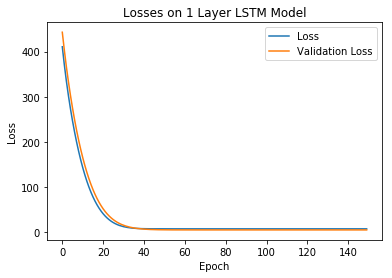

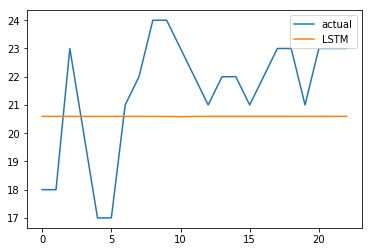

In [27]:
# show score
print("Training time: {:0.2f} seconds".format(end_time))
lstm_predict = lstm_1.predict(X_PICU_test_rnn)
lstm_1_score = lstm_1.evaluate(X_PICU_test_rnn,Y_PICU_test_rnn,verbose=0)
print("Loss {:0.3f}".format(lstm_1_score[0]))
print("Mean Absolute Error {:0.3f}".format(lstm_1_score[1]))
# plot loss
plt.plot(lstm_1_history.history['loss'],label="Loss")
plt.plot(lstm_1_history.history['val_loss'],label="Validation Loss")
plt.title("Losses on 1 Layer LSTM Model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
# plot test series
plt.plot(Y_PICU_test_rnn[:,0,0],label='actual')
plt.plot(lstm_predict[:,0,0],label='LSTM')
plt.legend()
plt.show()

# Results

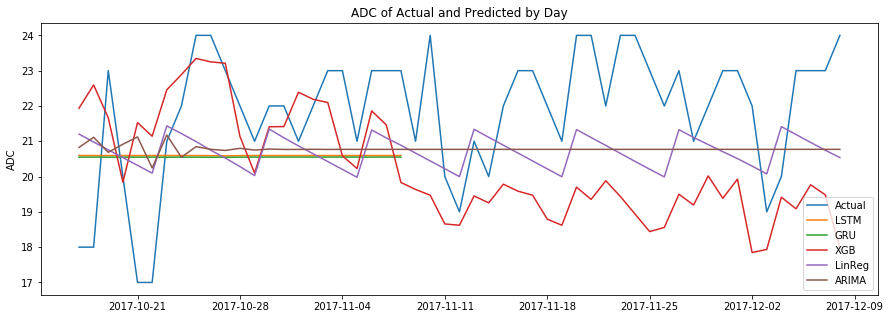

In [28]:
# show error on predicted ADC Daily
plt.figure(figsize=(15,5))
df_PICU_true = df_PICU.loc[int(len(df_PICU.index)*.66):,:]
x_eval_dates = df_PICU['EffectiveDAte'].loc[Y_PICU_test.index]
plt.plot(x_eval_dates,Y_PICU_test.values,label="Actual")
plt.plot(df_PICU['EffectiveDAte'].loc[Y_PICU_test.index[:-rnn_forecast_size]],lstm_predict[:,0,0], label="LSTM")
plt.plot(df_PICU['EffectiveDAte'].loc[Y_PICU_test.index[:-rnn_forecast_size]],gru_predict[:,0,0], label="GRU")
plt.plot(x_eval_dates,Y_PICU_xgb_pred[:len(Y_PICU_test.index)],label="XGB")
plt.plot(x_eval_dates,lr_pred[:len(Y_PICU_test.index)],label="LinReg")
plt.plot(x_eval_dates,arima_forecast[:len(Y_PICU_test.index)], label="ARIMA")
plt.title("ADC of Actual and Predicted by Day")
plt.ylabel("ADC")
plt.legend()
plt.show()

In [29]:
# find Monthly averages
df_PICU_true_M = df_PICU_true.groupby(by=[df_PICU_true.EffectiveDAte.dt.month]).mean()
test_months = {4:30,5:31,6:30,7:31,8:31,9:30,10:31,11:30,12:31}
start_date = '2016-03-28'
df_time_eval = pd.DataFrame()
### forecast arrays
arima_forecasts,xgb_forecasts,lr_forecasts,gru_forecasts,lstm_forecasts = [],[],[],[],[]
for test_month in list(test_months.keys())[1:]:
    # use all data up until first day of next month
    end_date = "2017-" + str(test_month-1) + "-" + str(test_months[test_month-1])
    df_PICU_curr = df_PICU[df_PICU['EffectiveDAte'].isin(pd.date_range(start = start_date,end=end_date))]
    ### train models
    # arima
    start_time = time.time()
    arima_model = ARIMA(df_PICU_curr['AverageCensusCount'], 
                      order=order
                     )
    arima_model_fit = arima_model.fit()
    arima_forecast,_,_ = arima_model_fit.forecast(steps=test_months[test_month])
    arima_forecasts.append(arima_forecast)
    df_time_eval.loc[test_month,"ARIMA"] = time.time()-start_time
    # xgb
    start_time=time.time()
    Y_PICU_curr_xgb = df_PICU_curr['AverageCensusCount']
    X_PICU_curr_xgb = X_PICU_xgb[df_PICU_xgb["EffectiveDAte"].isin(pd.date_range(start=start_date,end=end_date))]
    next_month = pd.date_range(start=end_date,end="2017-" + str(test_month) + "-" + str(test_months[test_month]))
    X_PICU_pred_xgb = X_PICU_xgb[df_PICU_xgb["EffectiveDAte"].isin(next_month)]
    xgb_PICU_model = xgb.train(params, xgb.DMatrix(X_PICU_curr_xgb,label=Y_PICU_curr_xgb), num_boost_round=500)
    xgb_forecasts.append(xgb_PICU_model.predict(xgb.DMatrix(X_PICU_pred_xgb)))
    df_time_eval.loc[test_month,"XGB"] = time.time()-start_time
    # Linear Regression
    start_time=time.time()
    lr_model = LinearRegression()
    lr_model.fit(X_PICU_curr_xgb.fillna(0),Y_PICU_curr_xgb)
    lr_forecasts.append(lr_model.predict(X_PICU_pred_xgb.fillna(0)))
    df_time_eval.loc[test_month,"LinReg"] = time.time()-start_time
    # GRU / LSTM
    df_seq_train = seq_split(df_PICU_curr['AverageCensusCount'],window_size=window_size)
    X_PICU_train_rnn_temp = df_seq_train.iloc[:,:-1]
    Y_PICU_train_rnn_temp = df_seq_train.iloc[:,-1]
    # reshape for LSTM
    X_PICU_train_rnn = np.reshape(X_PICU_train_rnn_temp.values, (len(X_PICU_train_rnn_temp), 1, X_PICU_train_rnn_temp.shape[1]))
    rnn_forecast_size = test_months[test_month]
    Y_seq_train = seq_split(Y_PICU_train_rnn_temp,window_size=rnn_forecast_size)
    #reshape outputs
    Y_PICU_train_rnn = np.reshape(Y_seq_train.values,(Y_seq_train.shape[0],1,Y_seq_train.shape[1]))
    Y_PICU_train_rnn = Y_PICU_train_rnn[:-1]
    X_PICU_train_rnn = X_PICU_train_rnn[:-(rnn_forecast_size+1)]
    X_PICU_test_rnn = X_PICU_train_rnn[-1]
    X_PICU_test_rnn = np.reshape(X_PICU_test_rnn,(X_PICU_test_rnn.shape[0],1,X_PICU_test_rnn.shape[1]))
    # train models
        # gru
    start_time = time.time()
    gru = Sequential()
    gru.add(GRU(64,input_shape=(X_PICU_train_rnn.shape[1],X_PICU_train_rnn.shape[2]),return_sequences=True))
    gru.add(TimeDistributed(Dense(rnn_forecast_size+1)))
    gru.compile(loss='mean_squared_error', 
               optimizer='adam',
               metrics=['mae'])
    gru_history = gru.fit(X_PICU_train_rnn, Y_PICU_train_rnn, 
                            epochs=50, 
                            batch_size=8, 
                            shuffle=False,
                            verbose=0
                           )
    df_time_eval.loc[test_month,"GRU"] = time.time()-start_time
    # lstm
    start_time=time.time()
    lstm_1 = Sequential()
    lstm_1.add(LSTM(32, input_shape=(X_PICU_train_rnn.shape[1],X_PICU_train_rnn.shape[2]),return_sequences=True))
    lstm_1.add(TimeDistributed(Dense(rnn_forecast_size+1)))
    lstm_1.compile(loss='mean_squared_error', 
               optimizer='adam',
               metrics=['mae'])
    lstm_1_history = lstm_1.fit(X_PICU_train_rnn, Y_PICU_train_rnn, 
                            epochs=150, 
                            batch_size=8, 
                            shuffle=False,
                            verbose=0
                           )
    df_time_eval.loc[test_month,"LSTM"] = time.time()-start_time
    # predict
    gru_forecasts.append(gru.predict(X_PICU_test_rnn))
    lstm_forecasts.append(lstm_1.predict(X_PICU_test_rnn))
# average each month and add to results df
arima_forecasts_means=[]
xgb_forecasts_means = []
lr_forecasts_means = []
gru_forecasts_means = []
lstm_forecasts_means= []
for month in range(len(arima_forecasts)):
    arima_forecasts_means.append(np.mean(arima_forecasts[month]))
    xgb_forecasts_means.append(np.mean(xgb_forecasts[month]))
    lr_forecasts_means.append(np.mean(lr_forecasts[month]))
    gru_forecasts_means.append(np.mean(gru_forecasts[month]))
    lstm_forecasts_means.append(np.mean(lstm_forecasts[month]))
df_PICU_true_M['ARIMA'] = arima_forecasts_means
df_PICU_true_M['XGBoost'] = xgb_forecasts_means
df_PICU_true_M['Linear Regression'] = lr_forecasts_means
df_PICU_true_M['GRU'] = gru_forecasts_means
df_PICU_true_M['LSTM'] = lstm_forecasts_means

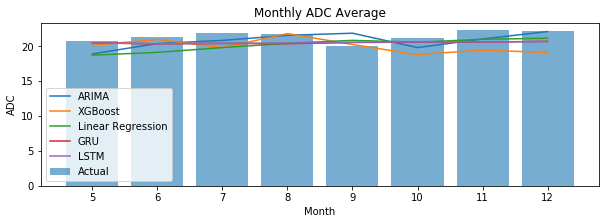

Target (Under 10% MAPE)	 2.1391297043010753
ARIMA	 1.053327053209212 +/- 0.6740645184667267
XGBoost	 1.449741731151458 +/- 1.2797048885663282
LinReg	 1.4056192834005459 +/- 0.5997083124673037
GRU	 1.0312021301638694 +/- 0.5424693624520752
LSTM	 1.021012835348806 +/- 0.5326298740142182


Average Training Time in seconds


ARIMA      5.846089
XGB        0.283742
LinReg     0.002043
GRU        8.560602
LSTM      21.874799
dtype: float64

In [30]:
# show averaged monthly ADC
plt.figure(figsize=(10,3))
plt.bar(df_PICU_true_M.index,df_PICU_true_M['AverageCensusCount'],label="Actual",alpha=.6)
plt.plot(df_PICU_true_M.index,df_PICU_true_M['ARIMA'],label="ARIMA")
plt.plot(df_PICU_true_M.index,df_PICU_true_M['XGBoost'],label="XGBoost")
plt.plot(df_PICU_true_M.index,df_PICU_true_M['Linear Regression'],label="Linear Regression")
plt.plot(df_PICU_true_M.index,df_PICU_true_M['GRU'],label="GRU")
plt.plot(df_PICU_true_M.index,df_PICU_true_M['LSTM'],label="LSTM")
plt.title("Monthly ADC Average")
plt.ylabel("ADC")
plt.xlabel("Month")
plt.legend()
plt.show()
# error metrics
arima_error = abs(df_PICU_true_M['AverageCensusCount'] - df_PICU_true_M['ARIMA'])
xgb_error = abs(df_PICU_true_M['AverageCensusCount'] - df_PICU_true_M['XGBoost'])
lr_error = abs(df_PICU_true_M['AverageCensusCount'] - df_PICU_true_M['Linear Regression'])
gru_error = abs(df_PICU_true_M['AverageCensusCount'] - df_PICU_true_M['GRU'])
lstm_error = abs(df_PICU_true_M['AverageCensusCount'] - df_PICU_true_M['LSTM'])
print("Target (Under 10% MAPE)\t",0.1 * df_PICU_true_M['AverageCensusCount'].mean())
print("ARIMA\t",arima_error.mean(),"+/-",arima_error.std())
print("XGBoost\t",xgb_error.mean(),"+/-",xgb_error.std())
print("LinReg\t",lr_error.mean(),"+/-",lr_error.std())
print("GRU\t",gru_error.mean(),"+/-",gru_error.std())
print("LSTM\t",lstm_error.mean(),"+/-",lstm_error.std())
# training time
print("\n\nAverage Training Time in seconds")
display(df_time_eval.mean())

# Evaluation
From the errors, we can see that each model performs within standard requirements. There are obviously models which perform best, but at the cost of predictive power. If we were solely tasked with predicting the monthly ADC with the lowest error then we could choose LSTM and productionize it. However, we are also looking to give nursing managers an idea of how the ADC will change throughout the month, giving them the ability to adapt their nursing needs to the number of patients their department will see. The most adaptable model, XGBoost, clearly mirrors the actual ADC activity throughout the month. From this, nursing managers will also be informed of excessively high or low ADC ahead of time. Ultimately, the ability to adapt nursing staff schedules to the number of patients is what will drive more efficient work and costs.